In [1]:
import numpy as np

def score (x,y, blossom_matrix, amino_acids):

    m=len(x)
    n=len(y)

    sm= np.zeros((n+1,m+1))


    for i in range(n+1):
        sm[i][0]=max(0,-8*i)
    for i in range(m+1):
        sm[0][i]=max(0,-8*i)

    for i in range(1,n+1):
        for j in range(1,m+1):
            bb=blossom_matrix[amino_acids.index(y[i-1])][amino_acids.index(x[j-1])]
            sm[i][j]=max(0,sm[i-1][j]-8,sm[i][j-1]-8,sm[i-1][j-1]+bb )
    return max(map(max, sm))



In [ ]:
from numba import njit

@njit
def score_numba(x, y, blosum_matrix): # numba za ubrzanje
    m = len(x)
    n = len(y)
    sm = np.zeros((n+1, m+1))

    for i in range(n+1):
        sm[i, 0] = max(0, -8*i)
    for j in range(m+1):
        sm[0, j] = max(0, -8*j)

    for i in range(1, n+1):
        yi = y[i-1]
        for j in range(1, m+1):
            xj = x[j-1]
            bb = blosum_matrix[yi, xj]
            sm[i, j] = max(0, sm[i-1, j] - 8, sm[i, j-1] - 8, sm[i-1, j-1] + bb)

    return np.max(sm)



In [3]:
testna = "FVFGDSLSDA"
proteins_file = "zad4_AT.fasta"
blosum_file = "zad3_blosum50.txt"
acids_file = "zad3_acids.txt"
ids = []
kiseline = []
scores = []

In [17]:
f1=open(acids_file, "r")
amino_acids=f1.readline()
f1.close()

blosum_matrix=[]   
f1=open(blosum_file, "r")
for i in range(20):
    line=f1.readline()
    vc=line.split()
    blosum_matrix.append(vc[:])
for i in range(20):
    for j in range(20):
        blosum_matrix[i][j]=int(blosum_matrix[i][j])
f1.close()

In [59]:
from Bio import SeqIO

rijecnik = {znak: i for i,znak in enumerate(amino_acids)} # ovo je za numbu
testna_np = np.zeros(len(testna))
for i in range(len(testna)):
    testna_np[i] = rijecnik[testna[i]]


scores = []
blosum_matrix_np = np.array(blosum_matrix)
for i,record in enumerate(SeqIO.parse(proteins_file, "fasta")):
    ids.append(record.id)
    kiseline.append(record.seq)

    record_np = np.zeros(len(record.seq)) # ovo je prebacivanje u np za numba
    for i in range(len(record.seq)):
        record_np[i] = rijecnik[record.seq[i]]

    record_np = record_np.astype(np.int32)
    testna_np = testna_np.astype(np.int32)
    blosum_matrix_np = blosum_matrix_np.astype(np.int32)
    #print(testna_np.dtype, record_np.dtype, blosum_matrix_np.dtype)
        
    scores.append(score_numba(testna_np,record_np,blosum_matrix_np))

In [35]:
names = []

with open("zad4_AT_imena.txt", "r") as f: # tu ucitavam sva imena
    for line in f:
        line = line.strip()
        if line.startswith(">"):
            # Ukloni znak '>' i podijeli po '|'
            parts = line[1:].split('|')
            
            names.append(parts[0][:-3])


In [28]:
truth = []

with open("zad4_ATBioPositives.txt", "r") as f: #tu u truth stavljam one koji su pozitivni tj slicni testu
    for line in f:
        line = line.strip()
        truth.append(line)


In [38]:
scores_sorted= scores.copy()     
scores_sorted.sort(reverse=True)
scores_sorted = np.array(scores_sorted)  

sorted_indices = [i for i, _ in sorted(enumerate(scores), key=lambda x: x[1], reverse=True)]  # tu dobivam sortirane indekse 
pozitives = [names[i] for i in sorted_indices[:200]]

58.0

In [48]:
moji_pogotci = scores_sorted[:100]

In [ ]:
unik = np.unique(np.array(scores))[::-1]
granice = [np.sum(scores_sorted >= i) for i in unik] # granice su indeksi pozicija gdje se skokovi desili u sortiranom scoreovima


104


In [ ]:
tprs = []
fprs = []

positives  = list(set([names[i] for i in sorted_indices[:100]]))

tp = 0
fp = 0
tn = 0
fn = 0

print()
for name in positives:
    if name in truth:
        tp += 1
    else:
        fp +=1

ukupno = len(scores)
pozitivnih = len(truth)
negativnih = ukupno - pozitivnih # = fp + tn
tn = negativnih - fp
fn = pozitivnih - tp  

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
precision = tp / (tp+fp)


f1 = 2* (precision * tpr)/(precision + tpr)

print(tpr, fpr, len(positives))
print(f1)
tprs.append(tpr)
fprs.append(fpr)

0.6153846153846154 0.0007506155047138654 89
0.6632124352331606


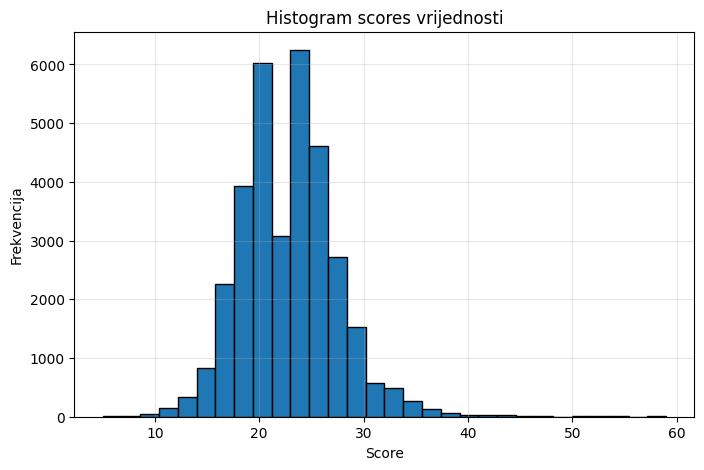

In [53]:
import matplotlib.pyplot as plt
import numpy as np




plt.figure(figsize=(8, 5))
plt.hist(scores, bins=30, edgecolor='black')  # možeš promijeniti broj binova po želji
plt.title('Histogram scores vrijednosti')
plt.xlabel('Score')
plt.ylabel('Frekvencija')
plt.grid(alpha=0.3)
plt.show()


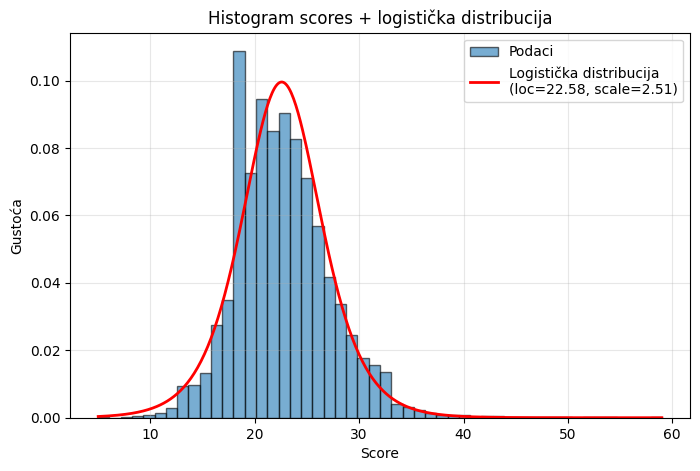

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import logistic

# pretpostavljam da već imaš scores = np.array([...])

# 1️⃣ Izračun parametara logističke distribucije iz podataka
loc, scale = logistic.fit(scores)  # loc = medijan, scale = "širina"

# 2️⃣ Histogram
plt.figure(figsize=(8, 5))
count, bins, _ = plt.hist(scores, bins=50, density=True, alpha=0.6, edgecolor='black', label='Podaci')

# 3️⃣ Logistička distribucija
x = np.linspace(min(scores), max(scores), 500)
pdf = logistic.pdf(x, loc=loc, scale=scale)
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Logistička distribucija\n(loc={loc:.2f}, scale={scale:.2f})')

# 4️⃣ Stilizacija
plt.title('Histogram scores + logistička distribucija')
plt.xlabel('Score')
plt.ylabel('Gustoća')
plt.legend()
plt.grid(alpha=0.3)
plt.show()